In [6]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Embedding
from nltk.tokenize import TweetTokenizer

I'm using dataset of tweets mentioning airlines as most of the tweets are either short or single sentence. It's good for sentence by sentence classifiation

Also using 300d embeddings pretrained on wiki

## Data prep

In [3]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        index_to_vec_map = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
            index_to_vec_map[words_to_index[w]] = word_to_vec_map[w]

        return words_to_index, index_to_words, word_to_vec_map, index_to_vec_map

words_to_index, index_to_words, word_to_vec_map, index_to_vec_map = read_glove_vecs("wiki-news-300d-1M.vec")

In [25]:
def parse_text(x,maxlen):
    tknzr = TweetTokenizer(reduce_len=True, strip_handles=True)

    x=x.apply(tknzr.tokenize)

    for i in x.index:
        words = []
        for word in x[i]:
            words.append(word_to_vec_map[word] if word in word_to_vec_map.keys() else np.zeros(300))
        x[i] = np.array(words)

    x_padded = keras.preprocessing.sequence.pad_sequences(x,maxlen=maxlen, dtype="float64")
    return x_padded

In [26]:
data = pd.read_csv("Tweets.csv")

x = data["text"]
y = data["airline_sentiment"]

y[y=='positive'] = 1
y[y=='neutral'] = 0
y[y=='negative'] = -1


x_padded = parse_text(x, 40)

/home/svk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/svk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/svk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Other data

Does not fit the project well as there are lost rewiews that have multiple sentiments while I go for simpler idea

In [ ]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data()

In [ ]:
y_train[y_train==0] = -1
y_test[y_test==0] = -1

In [ ]:
vocab = pd.read_csv('data/aclImdb/imdb.vocab',header=None)

In [ ]:
def parse_imdb(x,maxlen):
    for i in range(x.shape[0]):
        x[i] = np.array([word_to_vec_map[x[i][o]] if x[i][o] in word_to_vec_map.keys() else np.zeros(300) for o in range(len(x[i])-25 if len(x[i])-25>0 else 0,len(x[i]))])
    
    x_padded = keras.preprocessing.sequence.pad_sequences(x,maxlen=maxlen, dtype="float64")
    return x_padded

In [ ]:
def decode(seq):
    ret = np.zeros(len(seq),dtype='object')
    for i in range(len(seq)):
        ret[i] = vocab[0][seq[i]]
    return ret

In [ ]:
x_decoded = parse_imdb(np.vectorize(decode)(x_train),maxlen=25)

In [ ]:
x_t = parse_imdb(np.vectorize(decode)(x_test),maxlen=40)

## Book reading

In [ ]:
book_name = 'data/A Game Of Thrones - George R. R. Martin.txt'

text = []
with open(book_name,'r',encoding='UTF-8') as f:
    for line in f:
        sequences = line.strip().split('.')
        text.extend(sequences)
book = pd.Series(text)
book = book.drop_duplicates()

In [ ]:
book_parsed = parse_text(book[58:],maxlen=40)

In [ ]:
book_parsed.shape

In [ ]:
book_sentiment = model.predict(book_parsed)

## Model

For sentiment analysis I use LSTM model to analyze sentences and predict sentiment on scale from 1 to -1 (1 - pos,0 - neutral,-1 - neg)

In [31]:
model = Sequential()
model.add(LSTM(32,input_shape=(None,x_padded.shape[2]),return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(1, activation='tanh'))
# [LSTM(32,input_shape=(None,x_decoded.shape[2]),return_sequences=False),
#                    #LSTM(32,return_sequences=False),
#                     BatchNormalization(),
#                     Dense(1, activation='tanh')])

# define the checkpoint
filepath="checkpoints/MSE_weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.compile(optimizer="adam",metrics=['accuracy'],loss='mean_squared_error')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                42624     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 42,785
Trainable params: 42,721
Non-trainable params: 64
_________________________________________________________________


In [ ]:
hist = model.fit(x_padded,y, batch_size=256, epochs=50,validation_split=0.1,callbacks=callbacks_list)

In [34]:
model.load_weights("checkpoints/MSE_weights-improvement-01-0.1071.hdf5")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_padded,y, test_size=0.2)

In [35]:
model.evaluate(x_padded,y)

14640/14640 [==============================] - 7s 461us/step


[0.18271126856040107, 0.7952185792349726]

## Other sentiment analyzers

 As multiple libs have their own sentiment analyzers, I compared them with mine. From 3 I chose to compare TextBlob was easiest to use but relatively the worst in accuracy, NLTK has great non-DL solution, that gives only sligtly lower accuracy, and spaCy offers very similar analyzer to the one I'm using, just heavier. If given more resourses to train, I would have probably just used spaCy

### NLTK

In [18]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn.model_selection import train_test_split

In [19]:
sent_an = SentimentAnalyzer()

tknzr = TweetTokenizer(reduce_len=True, strip_handles=True)

x_tknz=x.apply(tknzr.tokenize)

x_tknz = np.array(x_tknz)

y[y==1] = "pos"
y[y==0] = "neu"
y[y==-1] = 'neg'

/home/svk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/svk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/svk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_pat

In [20]:
training_set_x,testing_set_x,training_set_y,testing_set_y = train_test_split(x_tknz,y)

training_set = np.vstack([training_set_x,training_set_y]).T

testing_set = np.vstack([testing_set_x,testing_set_y]).T

all_words_neg = sent_an.all_words([mark_negation(doc) for doc in training_set.T[0]])

unigram_feats = sent_an.unigram_word_feats(all_words_neg, min_freq=4)

In [21]:
len(unigram_feats)

3453

In [22]:
sent_an.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

trai_s = training_set.tolist()

test_s = testing_set.tolist()

train = sent_an.apply_features(trai_s)

test = sent_an.apply_features(test_s)

In [23]:
trainer = NaiveBayesClassifier.train
classifier = sent_an.train(trainer, train)

Training classifier


In [24]:
for key,value in sorted(sent_an.evaluate(test).items()):
    print('{0}: {1}'.format(key, value))

Evaluating NaiveBayesClassifier results...
Accuracy: 0.7882513661202186
F-measure [neg]: 0.8664292074799643
F-measure [neu]: 0.6465028355387523
F-measure [pos]: 0.686543110394843
Precision [neg]: 0.8910256410256411
Precision [neu]: 0.6364764267990074
Precision [pos]: 0.6358208955223881
Recall [neg]: 0.8431542461005199
Recall [neu]: 0.6568501920614597
Recall [pos]: 0.7460595446584939


### SpaCy

In [3]:
#run code block at the bottom of notebook before this block

@plac.annotations(
    train_dir=("Location of training file or directory"),
    dev_dir=("Location of development file or directory"),
    model_dir=("Location of output model directory",),
    is_runtime=("Demonstrate run-time usage", "flag", "r", bool),
    nr_hidden=("Number of hidden units", "option", "H", int),
    max_length=("Maximum sentence length", "option", "L", int),
    dropout=("Dropout", "option", "d", float),
    learn_rate=("Learn rate", "option", "e", float),
    nb_epoch=("Number of training epochs", "option", "i", int),
    batch_size=("Size of minibatches for training LSTM", "option", "b", int),
    nr_examples=("Limit to N examples", "option", "n", int),
)
def main(
    model_dir=".",
    train_dir=None,
    dev_dir=None,
    is_runtime=False,
    nr_hidden=64,
    max_length=100,  # Shape
    dropout=0.5,
    learn_rate=0.001,  # General NN config
    nb_epoch=5,
    batch_size=256,
    nr_examples=-1,
):  # Training params
    if model_dir is not None:
        model_dir = pathlib.Path(model_dir)
    if train_dir is None or dev_dir is None:
        imdb_data = thinc.extra.datasets.imdb()
    if is_runtime:
        if dev_dir is None:
            dev_texts, dev_labels = zip(*imdb_data[1])
        else:
            dev_texts, dev_labels = read_data(dev_dir)
        acc = evaluate(model_dir, dev_texts, dev_labels, max_length=max_length)
        print(acc)
    else:
        if train_dir is None:
            train_texts, train_labels = zip(*imdb_data[0])
        else:
            print("Read data")
            train_texts, train_labels = read_data(train_dir, limit=nr_examples)
        if dev_dir is None:
            dev_texts, dev_labels = zip(*imdb_data[1])
        else:
            dev_texts, dev_labels = read_data(dev_dir, imdb_data, limit=nr_examples)
        train_labels = numpy.asarray(train_labels, dtype="int32")
        dev_labels = numpy.asarray(dev_labels, dtype="int32")
        lstm = train(
            train_texts,
            train_labels,
            dev_texts,
            dev_labels,
            {"nr_hidden": nr_hidden, "max_length": max_length, "nr_class": 1},
            {"dropout": dropout, "lr": learn_rate},
            {},
            nb_epoch=nb_epoch,
            batch_size=batch_size,
        )
        weights = lstm.get_weights()
        if model_dir is not None:
            with (model_dir / "model").open("wb") as file_:
                pickle.dump(weights[1:], file_)
            with (model_dir / "config.json").open("w") as file_:
                file_.write(lstm.to_json())


# if __name__ == "__main__":
#     plac.call(main)


In [4]:
main()

Loading spaCy
Parsing texts...
Train on 310247 samples, validate on 304104 samples
Epoch 1/5
310247/310247 [==============================] - 1438s 5ms/step - loss: 0.6010 - acc: 0.6716 - val_loss: 0.5763 - val_acc: 0.6920
Epoch 2/5
310247/310247 [==============================] - 1441s 5ms/step - loss: 0.5746 - acc: 0.6953 - val_loss: 0.5670 - val_acc: 0.7026
Epoch 3/5
310247/310247 [==============================] - 1419s 5ms/step - loss: 0.5642 - acc: 0.7029 - val_loss: 0.5637 - val_acc: 0.7077
Epoch 4/5
310247/310247 [==============================] - 1436s 5ms/step - loss: 0.5572 - acc: 0.7091 - val_loss: 0.5583 - val_acc: 0.7099
Epoch 5/5
310247/310247 [==============================] - 1439s 5ms/step - loss: 0.5517 - acc: 0.7130 - val_loss: 0.5553 - val_acc: 0.7127


### TextBlob

In [27]:
from textblob import TextBlob
from sklearn.metrics import mean_squared_error

In [28]:
x_blob = x.apply(TextBlob)

In [29]:
y_blob = x_blob.apply(lambda x: x.sentiment.polarity)

In [30]:
mean_squared_error(y,y_blob)

0.7450788778069388

## Visualisation

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_book(book_name):
    with open(book_name,'r',encoding='UTF-8') as f:
        text = []
        for line in f:
            sequences = line.strip().split('.')
            text.extend(sequences)
        text = pd.Series(text)
        text = text.drop_duplicates()
        text = parse_text(text,40)
        res = model.predict(text)
    reshaped = np.reshape(keras.preprocessing.sequence.pad_sequences([res], padding='post',maxlen=(int(np.sqrt(res.shape[0]))+1)**2, dtype="float64"),(int(np.sqrt(res.shape[0]))+1,-1))
    fig, ax = plt.subplots(figsize=(20,16))
    p1 = sns.heatmap(reshaped,cmap="PiYG")

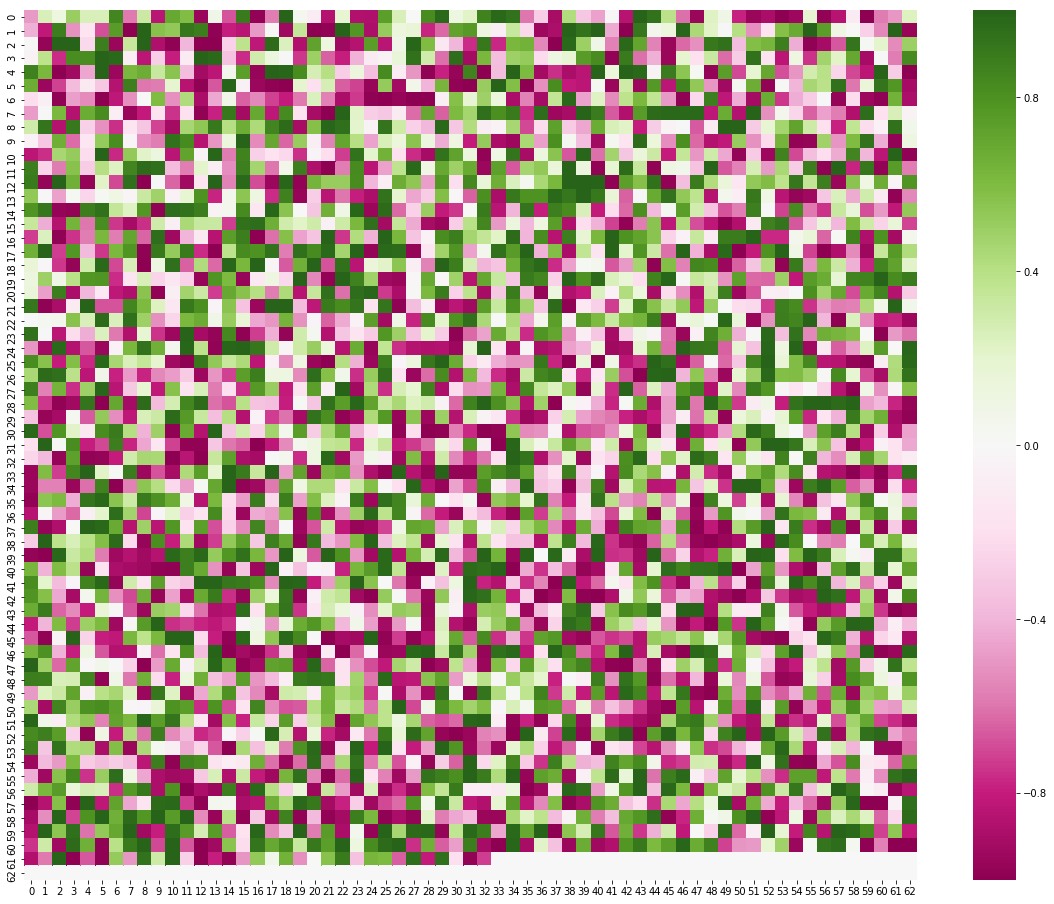

In [35]:
visualize_book("data/books/TREASURE ISLAND by Robert Louis Stevenson.txt")

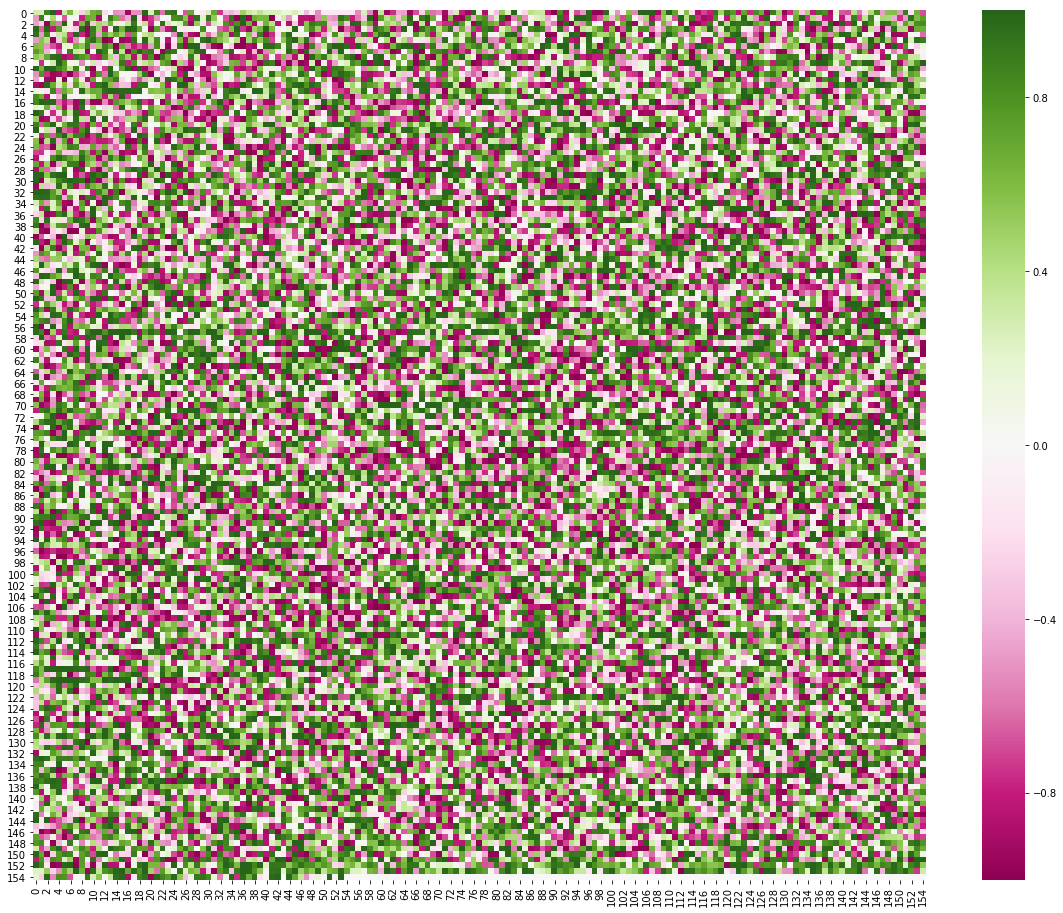

In [36]:
visualize_book("data/books/A Game Of Thrones - George R. R. Martin.txt")

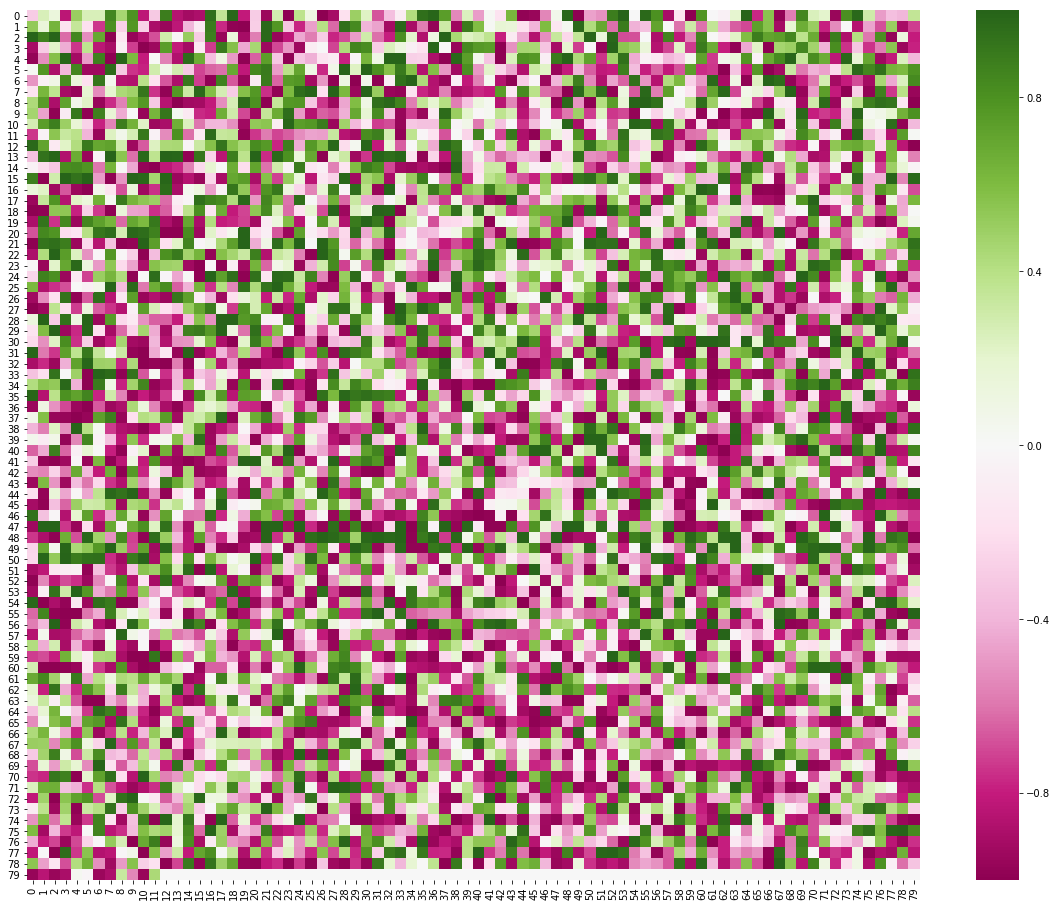

In [37]:
visualize_book("data/books/The Picture of Dorian Gray by Oscar Wilde.txt")

In [39]:
def vis_parsed(book_name):
    res = np.loadtxt(book_name)
    reshaped = np.reshape(keras.preprocessing.sequence.pad_sequences([res], padding='post',maxlen=(int(np.sqrt(res.shape[0]))+1)**2, dtype="float64"),(int(np.sqrt(res.shape[0]))+1,-1))
    fig, ax = plt.subplots(figsize=(20,16))
    p1 = sns.heatmap(reshaped,cmap="PiYG")

## Parsing books

In [41]:
from os import listdir
from os.path import isfile, join
mypath = "data/books/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [43]:
for book in onlyfiles:
    with open(mypath+book,'r',encoding='UTF-8') as f:
        print("Working on", book)
        text = []
        for line in f:
            sequences = line.strip().split('.')
            text.extend(sequences)
        text = pd.Series(text)
        text = text.drop_duplicates()
        text = parse_text(text,40)
        res = model.predict(text)
        np.savetxt("data/p1/"+book,res)
        print("Done", book)

Working on 02-Short Stories-The Sword of D - Bradbury.txt
Done 02-Short Stories-The Sword of D - Bradbury.txt
Working on 04 Times of Contempt (1995) - Stephen.txt
Done 04 Times of Contempt (1995) - Stephen.txt
Working on 05 Baptism of Fire (1996) - Rebecca Nettleship.txt
Done 05 Baptism of Fire (1996) - Rebecca Nettleship.txt
Working on 06 The Tower of the Swallow (19 - Dominik.txt
Done 06 The Tower of the Swallow (19 - Dominik.txt
Working on 07 The Lady of the Lake (1999) - Stephen Hulin.txt
Done 07 The Lady of the Lake (1999) - Stephen Hulin.txt
Working on 08 Season of Storms (2013) - Stephen Hulin [Kinetic IT].txt
Done 08 Season of Storms (2013) - Stephen Hulin [Kinetic IT].txt
Working on 1984- GEORGE ORWELL.txt
Done 1984- GEORGE ORWELL.txt
Working on A CHRISTMAS CAROL By CHARLES DICKENS.txt
Done A CHRISTMAS CAROL By CHARLES DICKENS.txt
Working on A Clash of Kings - George R. R. Martin.txt
Done A Clash of Kings - George R. R. Martin.txt
Working on A Dance With Dragons_ Book 5 of - G

Done Memoirs of Fanny Hill - John Cleland.txt
Working on Memoirs of Sherlock Holmes - SIR ARTHUR CONAN DOYLE.txt
Done Memoirs of Sherlock Holmes - SIR ARTHUR CONAN DOYLE.txt
Working on Metamorphosis - Franz Kafka.txt
Done Metamorphosis - Franz Kafka.txt
Working on Middlemarch - George Eliot.txt
Done Middlemarch - George Eliot.txt
Working on Moby Dick by Herman Mellville.txt
Done Moby Dick by Herman Mellville.txt
Working on Nemesis Games - James S. A. Corey.txt
Done Nemesis Games - James S. A. Corey.txt
Working on NORTHANGER ABBEY by Jane Austen.txt
Done NORTHANGER ABBEY by Jane Austen.txt
Working on Nostromo - Joseph Conrad.txt
Done Nostromo - Joseph Conrad.txt
Working on Notes from the Underground - Fyodor Dostoyevsky.txt
Done Notes from the Underground - Fyodor Dostoyevsky.txt
Working on Of Mice and Men - John Steinbeck.txt
Done Of Mice and Men - John Steinbeck.txt
Working on Oliver Twist by Charles Dickens.txt
Done Oliver Twist by Charles Dickens.txt
Working on ONE HUNDRED YEARS OF 

## Spacy code block

In [37]:
import plac
import random
import pathlib
import cytoolz
import numpy
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
import thinc.extra.datasets
from spacy.compat import pickle
import spacy


class SentimentAnalyser(object):
    @classmethod
    def load(cls, path, nlp, max_length=100):
        with (path / "config.json").open() as file_:
            model = model_from_json(file_.read())
        with (path / "model").open("rb") as file_:
            lstm_weights = pickle.load(file_)
        embeddings = get_embeddings(nlp.vocab)
        model.set_weights([embeddings] + lstm_weights)
        return cls(model, max_length=max_length)

    def __init__(self, model, max_length=100):
        self._model = model
        self.max_length = max_length

    def __call__(self, doc):
        X = get_features([doc], self.max_length)
        y = self._model.predict(X)
        self.set_sentiment(doc, y)

    def pipe(self, docs, batch_size=1000):
        for minibatch in cytoolz.partition_all(batch_size, docs):
            minibatch = list(minibatch)
            sentences = []
            for doc in minibatch:
                sentences.extend(doc.sents)
            Xs = get_features(sentences, self.max_length)
            ys = self._model.predict(Xs)
            for sent, label in zip(sentences, ys):
                sent.doc.sentiment += label - 0.5
            for doc in minibatch:
                yield doc

    def set_sentiment(self, doc, y):
        doc.sentiment = float(y[0])
        # Sentiment has a native slot for a single float.
        # For arbitrary data storage, there's:
        # doc.user_data['my_data'] = y


def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        for sent in doc.sents:
            sentences.append(sent)
            labels.append(y)
    return sentences, numpy.asarray(labels, dtype="int32")


def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype="int32")
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs


def train(
    train_texts,
    train_labels,
    dev_texts,
    dev_labels,
    lstm_shape,
    lstm_settings,
    lstm_optimizer,
    batch_size=100,
    nb_epoch=5,
    by_sentence=True,
):

    print("Loading spaCy")
    nlp = spacy.load("en_vectors_web_lg")
    nlp.add_pipe(nlp.create_pipe("sentencizer"))
    embeddings = get_embeddings(nlp.vocab)
    model = compile_lstm(embeddings, lstm_shape, lstm_settings)

    print("Parsing texts...")
    train_docs = list(nlp.pipe(train_texts))
    dev_docs = list(nlp.pipe(dev_texts))
    if by_sentence:
        train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
        dev_docs, dev_labels = get_labelled_sentences(dev_docs, dev_labels)

    train_X = get_features(train_docs, lstm_shape["max_length"])
    dev_X = get_features(dev_docs, lstm_shape["max_length"])
    model.fit(
        train_X,
        train_labels,
        validation_data=(dev_X, dev_labels),
        epochs=nb_epoch,
        batch_size=batch_size,
    )
    return model


def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape["max_length"],
            trainable=False,
            weights=[embeddings],
            mask_zero=True,
        )
    )
    model.add(TimeDistributed(Dense(shape["nr_hidden"], use_bias=False)))
    model.add(
        Bidirectional(
            LSTM(
                shape["nr_hidden"],
                recurrent_dropout=settings["dropout"],
                dropout=settings["dropout"],
            )
        )
    )
    model.add(Dense(shape["nr_class"], activation="sigmoid"))
    model.compile(
        optimizer=Adam(lr=settings["lr"]),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


def get_embeddings(vocab):
    return vocab.vectors.data


def evaluate(model_dir, texts, labels, max_length=100):
    nlp = spacy.load("en_vectors_web_lg")
    nlp.add_pipe(nlp.create_pipe("sentencizer"))
    nlp.add_pipe(SentimentAnalyser.load(model_dir, nlp, max_length=max_length))

    correct = 0
    i = 0
    for doc in nlp.pipe(texts, batch_size=1000):
        correct += bool(doc.sentiment >= 0.5) == bool(labels[i])
        i += 1
    return float(correct) / i


def read_data(data_dir, limit=0):
    examples = []
    for subdir, label in (("pos", 1), ("neg", 0)):
        for filename in (data_dir / subdir).iterdir():
            with filename.open() as file_:
                text = file_.read()
            examples.append((text, label))
    random.shuffle(examples)
    if limit >= 1:
        examples = examples[:limit]
    return zip(*examples)  # Unzips into two lists